<a href="https://colab.research.google.com/github/Krankile/ensemble-forecasting/blob/main/weight_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [2]:
!pip install kora -q
from kora import drive
drive.link_nbs()
!pip install -U "pulp==2.1"

     |████████████████████████████████| 57 kB 1.4 MB/s 
     |████████████████████████████████| 56 kB 2.4 MB/s 
Mounted at /content/drive
     |████████████████████████████████| 40.6 MB 70 kB/s 


In [98]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpAffineExpression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from weight_net import feature_extractor
from matplotlib.ticker import PercentFormatter


Get some data

In [8]:
training_data = pd.read_csv('/content/drive/MyDrive/Master, Ankile og Krange/Data/epic_dataframe_of_doom.csv').set_index("id")

In [27]:
def find_best_weight(row_nr, forecasts, actuals):
    """This is a linear program for """
    model_count = len(forecasts[0][0])
    
    forecast_length = len(forecasts[0])

    model = LpProblem(name="best_weights")

    #(model_count,forecast_length)
    b = forecasts[0].numpy().T 
    
    y = actuals[0].numpy()
    
    x = {i:LpVariable(name=f"x{i}", lowBound=0) for i in range(model_count) }

    zp = {t: LpVariable(name=f"zp{t}", lowBound=0) for t in range(forecast_length)}
    
    zm = {t: LpVariable(name=f"zm{t}", lowBound=0) for t in range(forecast_length)}

    model += lpSum([zp[t]+zm[t] for t in range(forecast_length)])
    
    for t in range(forecast_length):
      
      #model += (( lpSum([x[i]*b[i][t] for i in range(model_count)] ) - y[t] <= zp[t]), f"postive zp_{t}") 
      model += (y[t] - LpAffineExpression([(x[i],b[i][t]) for i in range(model_count)]) <= zp[t], f"postive zp_{t}") 
      #model += (y[t] - (lpSum([x[i]*b[i][t] for i in range(model_count)]) <= zm[t]), f"negative zm_{t}")
      model += (LpAffineExpression([(x[i],b[i][t]) for i in range(model_count)], ) - y[t] <= zm[t], f"negative zm_{t}") 
    model += (lpSum([x[i] for i in range(model_count)]) == 1)

    status = model.solve()

    return model

row_nr = 3
loss_function_code = "mse"
row_nr = 44

_, forecasts, actuals = feature_extractor(training_data.iloc[[row_nr]], "m", "minmax")

model = find_best_weight(row_nr, forecasts, actuals)

for var in model.variables():
    print(f"{var.name}: {var.value()}")



x0: 0.061021014
x1: 0.0
x2: 0.51524878
x3: 0.0
x4: 0.0
x5: 0.0
x6: 0.42373021
zm0: 927.76065
zm1: 0.0
zm10: 0.0
zm11: 3011.7927
zm12: 1510.2326
zm13: 8030.8654
zm14: 2057.7092
zm15: 0.0
zm16: 3024.1705
zm17: 0.0
zm2: 0.0
zm3: 0.0
zm4: 1119.3
zm5: 1821.511
zm6: 1798.9936
zm7: 960.54598
zm8: 3082.1319
zm9: 1157.9748
zp0: 0.0
zp1: 1733.5864
zp10: 0.0
zp11: 0.0
zp12: 0.0
zp13: 0.0
zp14: 0.0
zp15: 7220.0712
zp16: 0.0
zp17: 9237.2007
zp2: 1407.3705
zp3: 0.0
zp4: 0.0
zp5: 0.0
zp6: 0.0
zp7: 0.0
zp8: 0.0
zp9: 0.0


Define a function which finds the optimal weights for the least absolute  

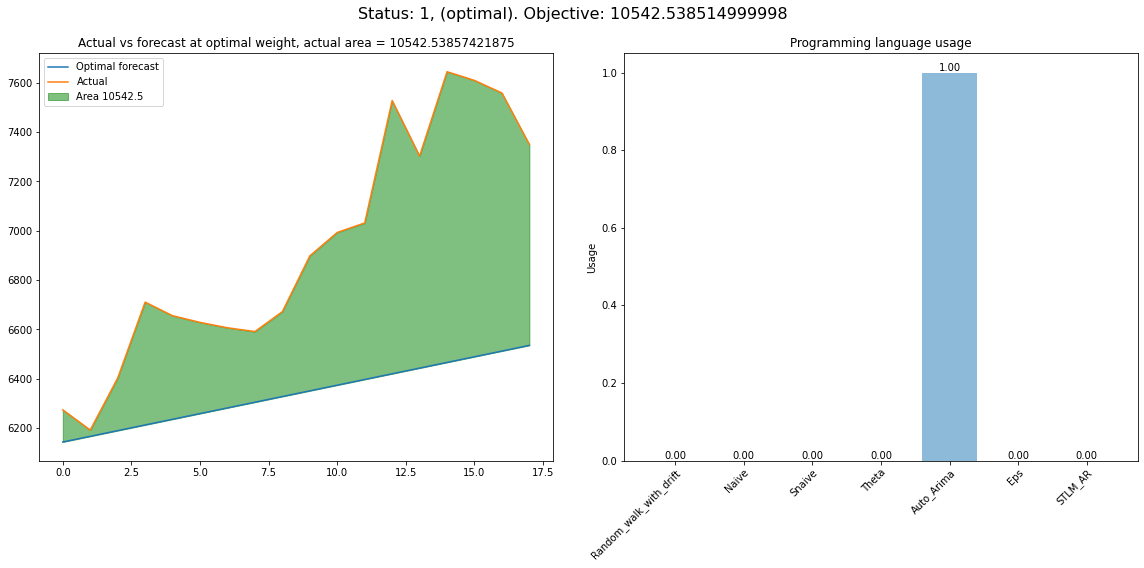

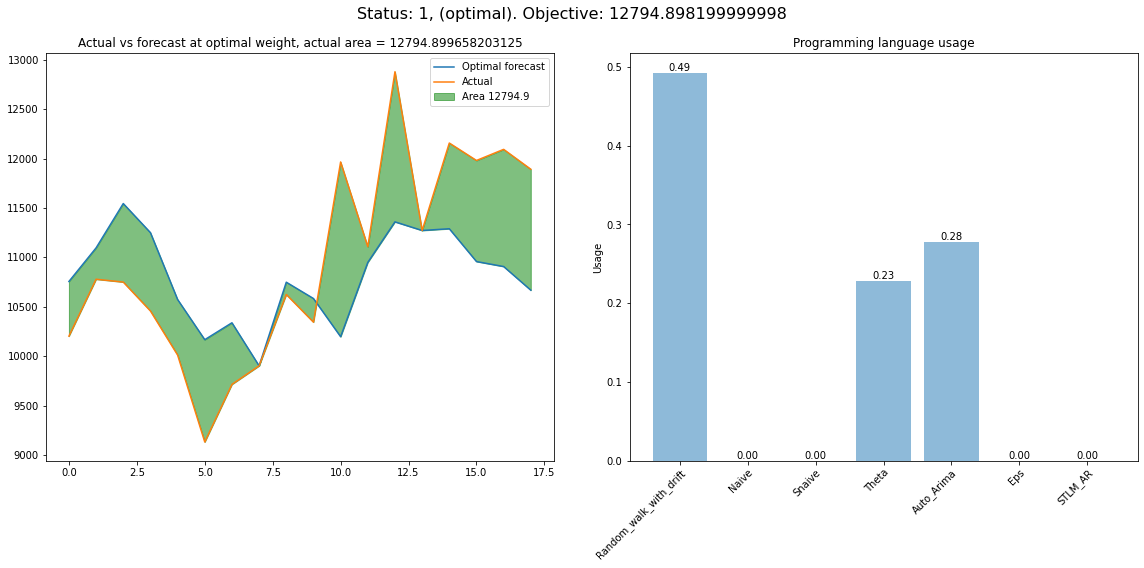

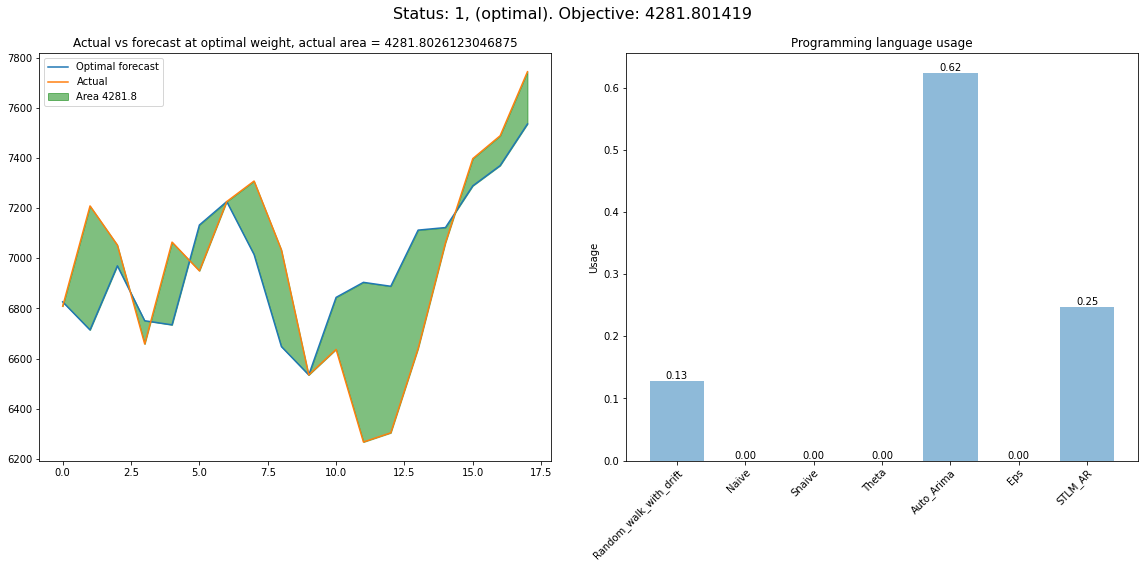

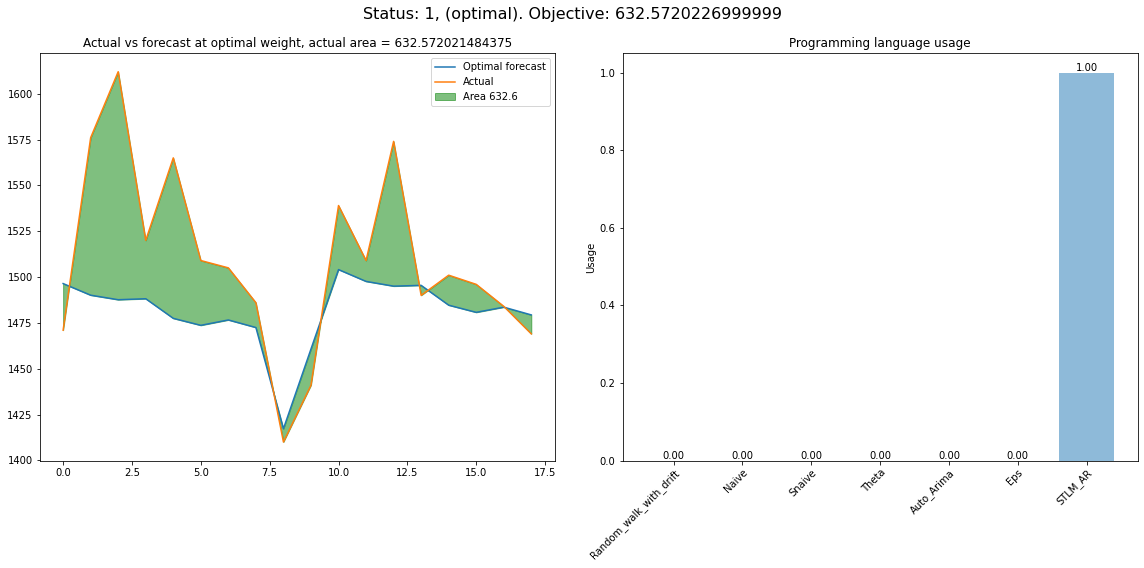

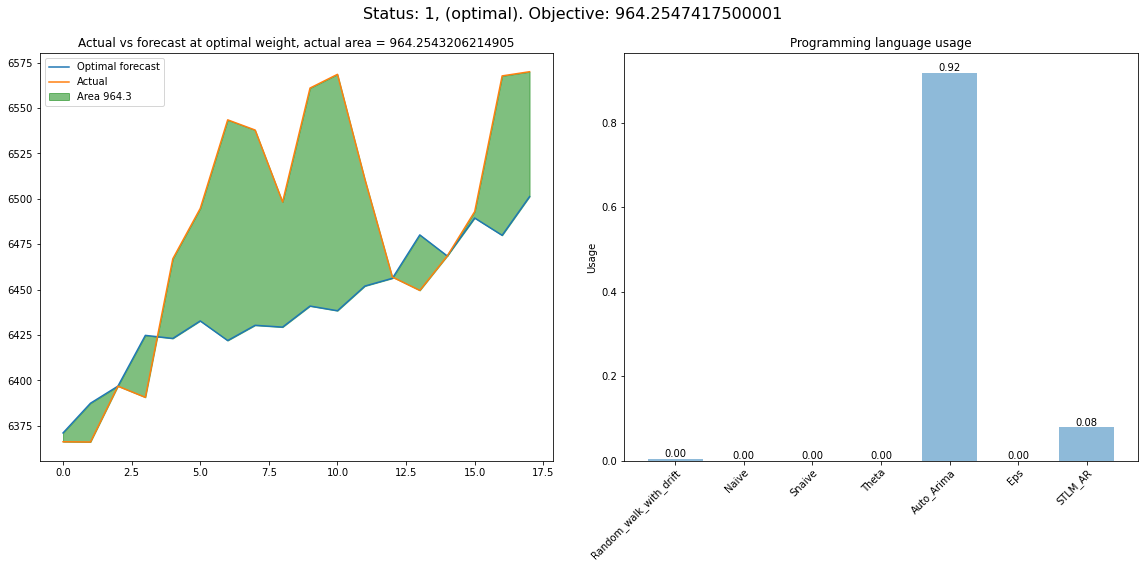

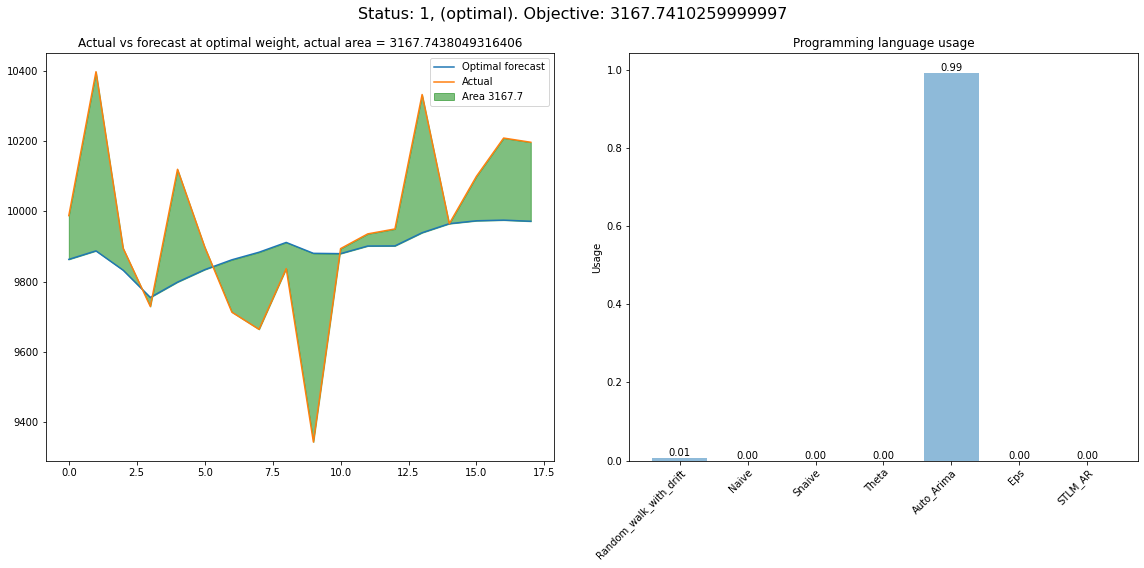

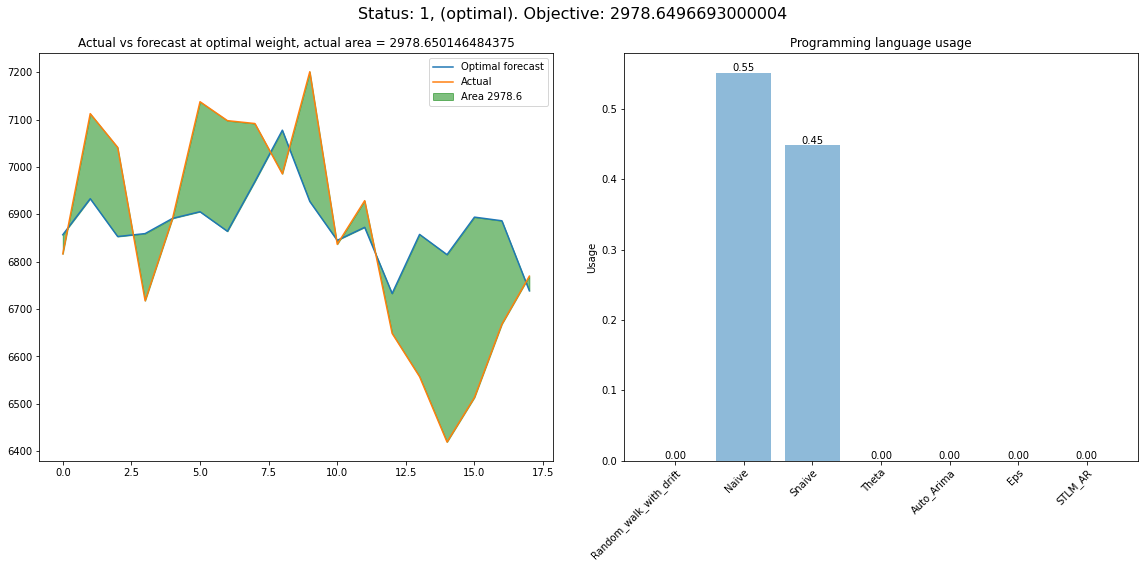

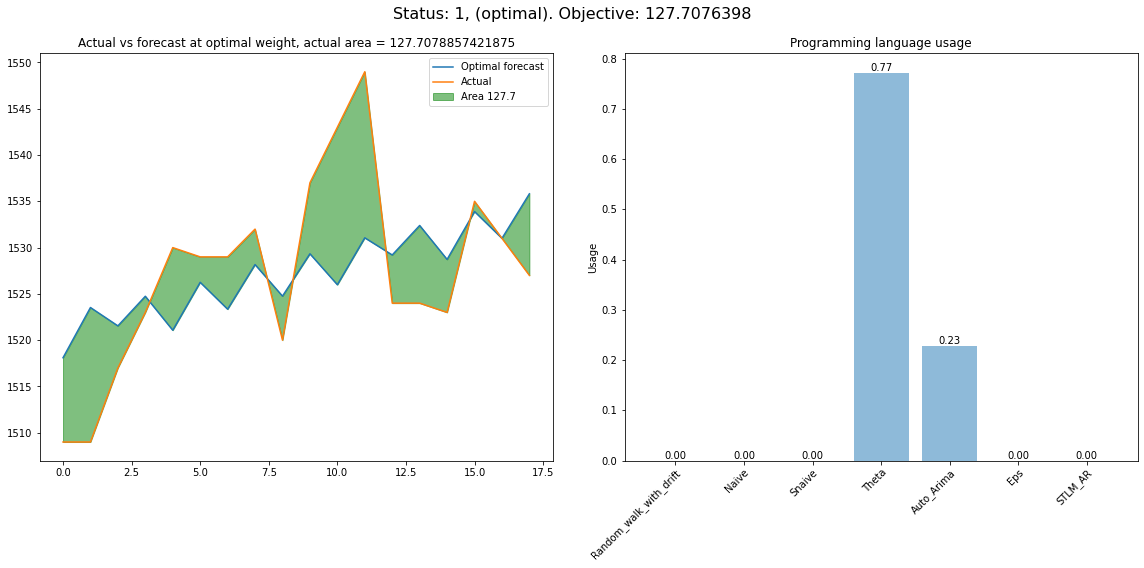

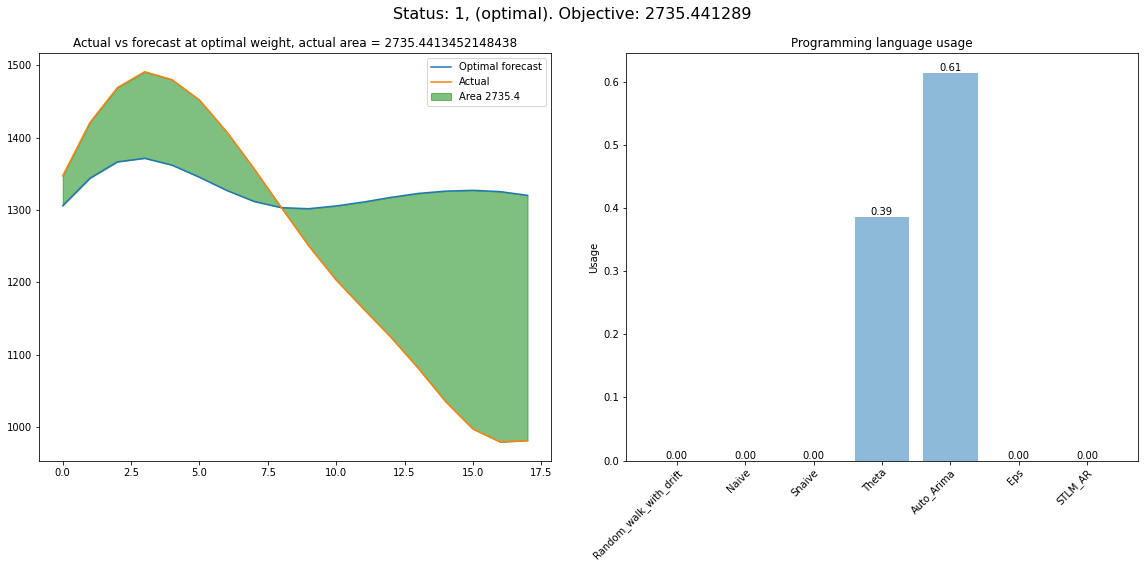

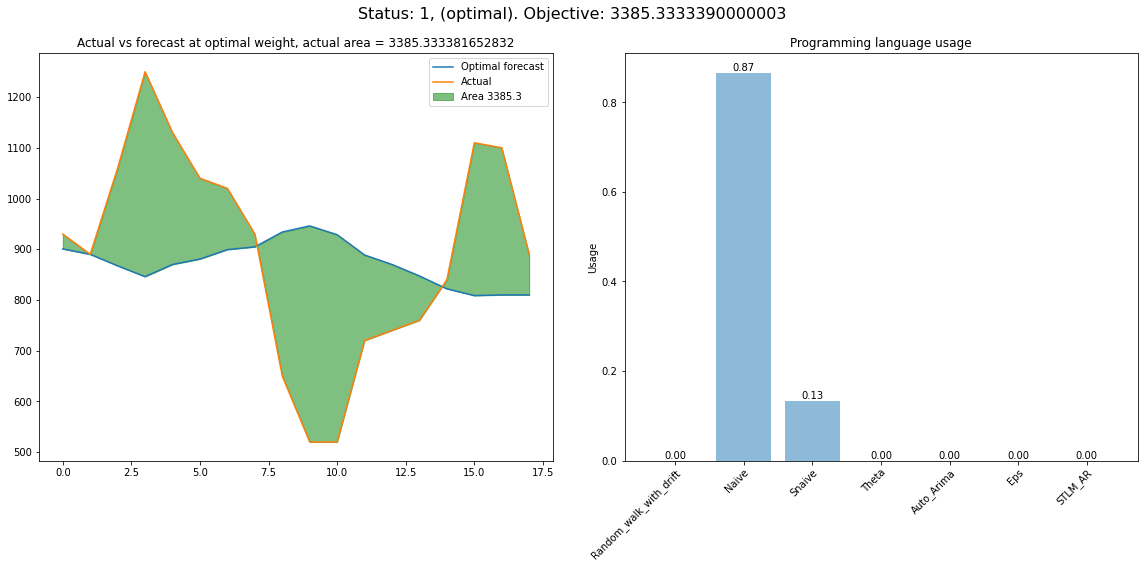

In [107]:
def get_optimal_weights(model_subset_as_string_lst, from_row, to_row, df):
  
  """The to_row variable is not inclusive"""
  row_weight_dicionary = {}
  model_to_forecast_index = {"Random_walk_with_drift":0,"Naive":1,"Snaive":2,"Theta":3,"Auto_Arima":4, "Eps":5, "STLM_AR":6}
  

  model_per_row = []
  
  for row_nr in range(from_row, to_row):
    
    #print(row_nr)
    
    _, forecasts, actuals = weight_net.feature_extractor(df.iloc[[row_nr]], "m", "minmax")

    #print(forecasts.shape)    
    
    used_forecasts = []
    
    for model in model_subset_as_string_lst:
      used_forecasts.append( forecasts[0].T[model_to_forecast_index[model] ])

    #print("used forecasts:", used_forecasts)

    model = find_best_weight(row_nr, forecasts, actuals)
    model_per_row.append(model)
    
    weights = []

    for i, var in enumerate(model.variables()):
      
      weights.append((var.value(), list(model_subset_as_string_lst)[i]) ) 
      
      if i == len(model_subset_as_string_lst) -1:
        break

    row_weight_dicionary[row_nr] = weights

  return row_weight_dicionary, model_per_row
  
model_dictionary = {"Random_walk_with_drift":0,"Naive":1,"Snaive":2,"Theta":3,"Auto_Arima":4, "Eps":5, "STLM_AR":6} 

  




def weights_to_forecasts(weights, row_nr):
  
  _, forecasts, actuals = feature_extractor(training_data.iloc[[row_nr]], "m", "minmax")
  
  model_to_forecast_index = {"Random_walk_with_drift":0,"Naive":1,"Snaive":2,"Theta":3,"Auto_Arima":4, "Eps":5, "STLM_AR":6}

  weighted_forecast = np.array([0.0]*18)
  
  for weight, model in weights:
      
      weighted_forecast += weight * np.array(forecasts[0].T[model_to_forecast_index[model]] )
  
  return weighted_forecast, actuals[0].numpy()
  

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height, f"{height:.2f}",
                ha='center', va='bottom')


def plot_area_between_to_functions(f, g, model, optimalweight):
  ts = [i for i in range(len(f))]

  actual_area = 0
  
  for i in range(len(f)):
    actual_area += abs( f[i]-g[i] )
    
  fig, (ax1, ax2) = plt.subplots(ncols=2)
  area = model.objective.value()

  ax1.fill_between(ts, f,g, color="green",alpha=0.5, label=f"Area {area:.1f}") 
  ax1.plot(f, label="Optimal forecast")
  ax1.plot(g, label="Actual")
  ax1.legend()
  ax1.set_title(f"Actual vs forecast at optimal weight, actual area = {actual_area}")
  
  


  weights, modelnames = zip(*optimalweight)
  y_pos = np.arange(len(modelnames))

  rects = ax2.bar(y_pos, weights, align='center', alpha=0.5)
  ax2.set_xticks(y_pos)
  ax2.set_xticklabels(modelnames)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  autolabel(rects, ax2)

  ax2.set_ylabel('Usage')
  ax2.set_title('Programming language usage')

  title = f"Status: {model.status}, ({str(LpStatus[model.status]).lower()}). Objective: {model.objective.value()}"
  fig.suptitle(title, fontsize=16)
  fig.tight_layout()
  fig.subplots_adjust(top=0.90)
  fig.show()

row_from = 90
row_to = 100
optimal_weights, models = get_optimal_weights(model_dictionary.keys(), row_from, row_to, training_data)

def plot_area_between_many_functions(row_from,row_to,models,optimal_weights):
  for row, model in zip(range(row_from, row_to), models):
    forecast, actual = weights_to_forecasts(optimal_weights[row], row)
    
    plot_area_between_to_functions(forecast, actual, model, optimal_weights[row])
    
#plot_area_between_many_functions(row_from, row_to, models, optimal_weights)

#Now we aggregate all the optimal weights

In [30]:
def get_many_many_weights(row_from, row_to)
  """This function will take a lot of computation if run over a large dataset"""
  row_from = 0
  row_to = 5000
  optimal_weights, models = get_optimal_weights(model_dictionary.keys(), row_from, row_to, training_data)
  return optimal_weights, models

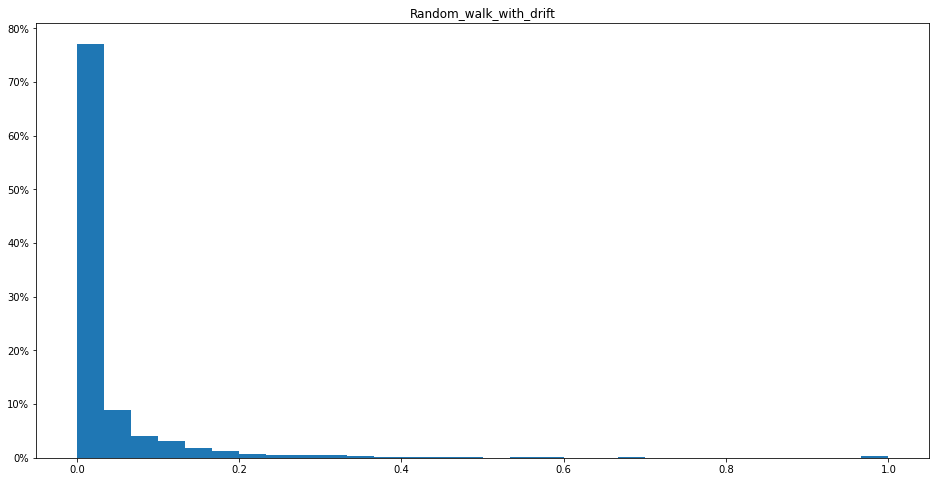

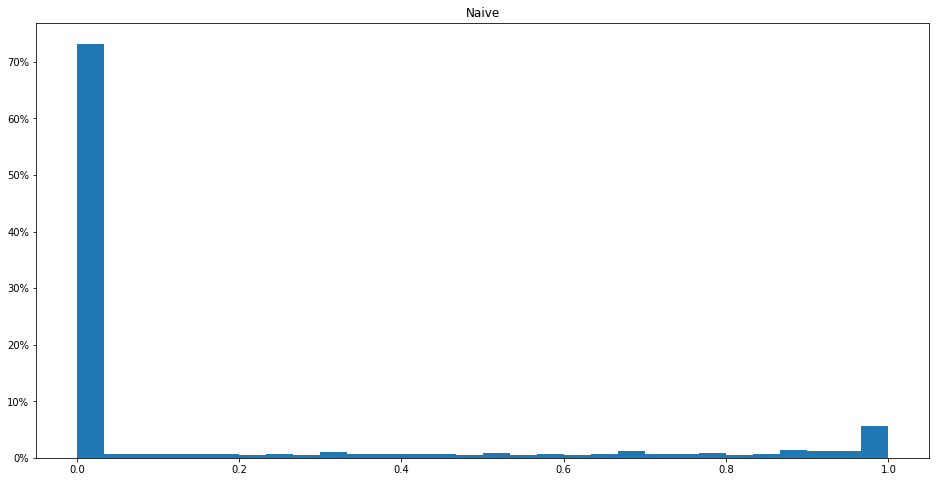

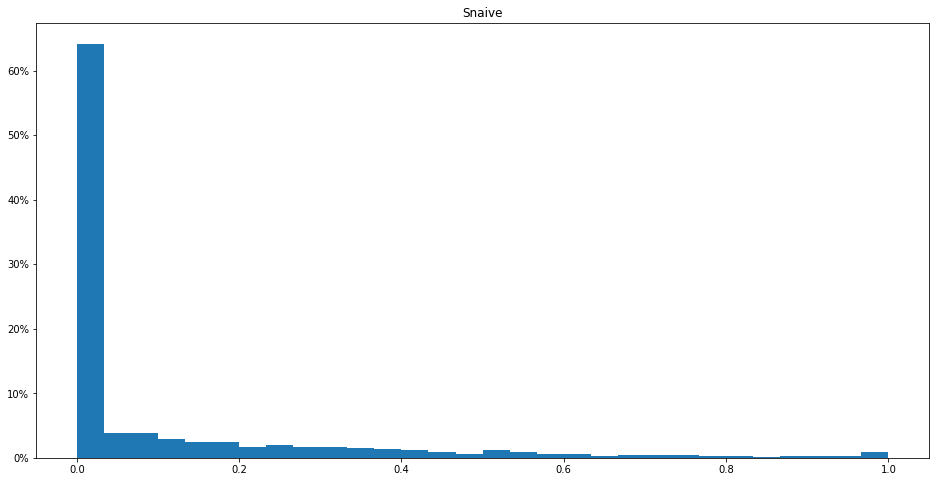

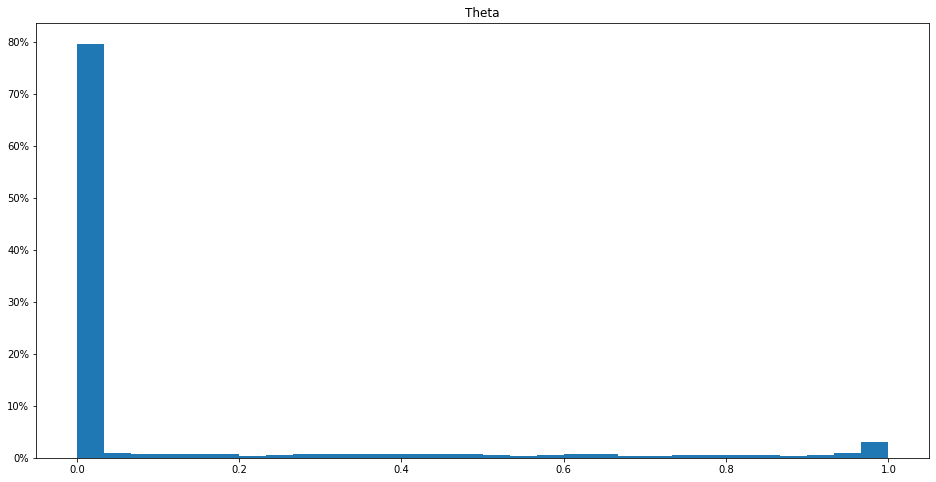

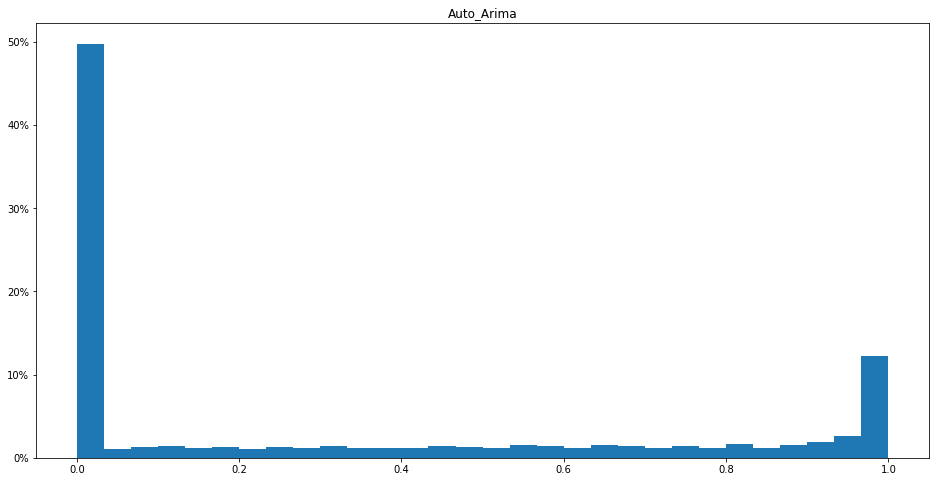

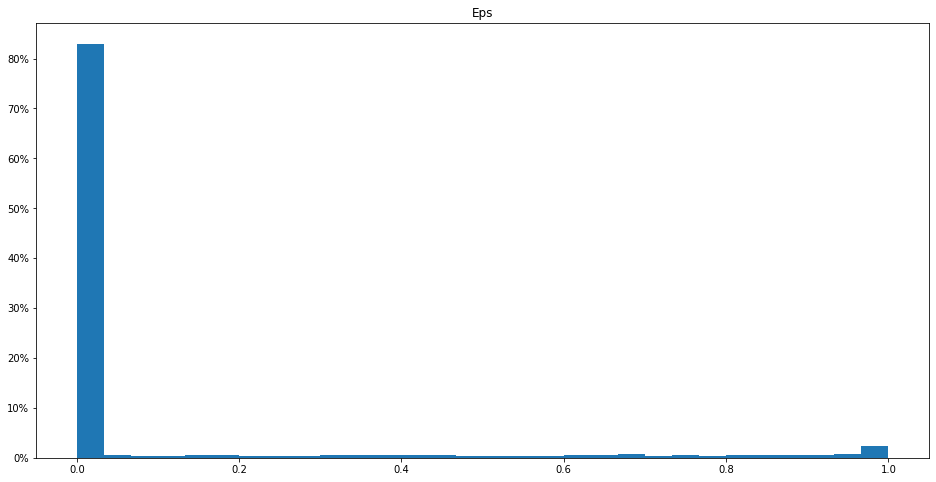

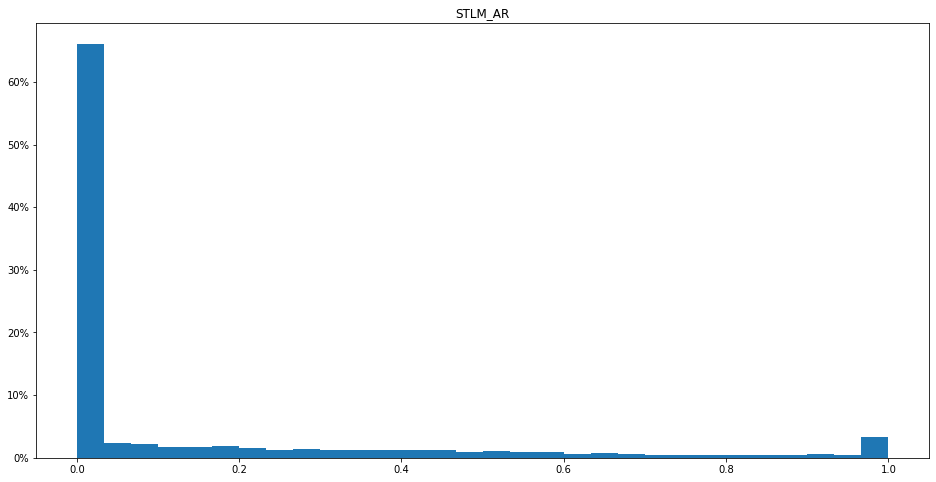

In [103]:
def plot_histogram(many_weights)
  models = list(model_dictionary.keys()) 
  aggregated_weights = {}

  for key in model_dictionary.keys():
    aggregated_weights[key] = []

  for row in optimal_weights.keys():

    for weight, model in optimal_weights[row]:
    
      aggregated_weights[model] += [weight]

  for key in aggregated_weights.keys():   
    plt.hist(aggregated_weights[key], bins=30,  weights=np.ones(len(aggregated_weights[key])) / len(aggregated_weights[key]))
    
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(key)
    plt.show()